In [1]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px

# Importar nuestro archivo de soporte
# -----------------------------------------------------------------------
import sys
sys.path.append('../..') #pongo los 2 puntos para que salga de la carpeta
from src import soporte_clustering as sc
from src import funciones as f
from src import soporte_prep as spp
from src import soporte_encoding as se

import warnings
warnings.filterwarnings('ignore')
import math

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../../Datos/df_predecir_1.csv', index_col=0)

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,cluster
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,1
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,1
2,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,1
3,31192,IN-2012-86369,14-04-2012,18-04-2012,Standard Class,MB-18085,Mick Brown,Consumer,Hamilton,Waikato,New Zealand,NaN,APAC,Oceania,FUR-TA-10002958,Furniture,Tables,"Chromcraft Conference Table, Fully Assembled",5244.840,6,0.0,996.4800,878.38,High,1
4,34577,CA-2011-102988,05-04-2011,09-04-2011,Second Class,GM-14695,Greg Maxwell,Corporate,Alexandria,Virginia,United States,22304.0,US,South,OFF-SU-10002881,Office Supplies,Supplies,Martin Yale Chadless Opener Electric Letter Op...,4164.050,5,0.0,83.2810,846.54,High,1


In [4]:
df.drop(columns=['State', 'Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Customer ID', 'City', 'Postal Code','Product ID', 'Product Name', 'Profit', 'cluster', 'Customer Name'], inplace=True)

In [5]:
df.head()

,Ship Mode,Segment,Country,Market,Region,Category,Sub-Category,Sales,Quantity,Discount,Shipping Cost,Order Priority
0,Same Day,Consumer,United States,US,East,Technology,Accessories,2309.650,7,0.0,933.57,Critical
1,Second Class,Corporate,Australia,APAC,Oceania,Furniture,Chairs,3709.395,9,0.1,923.63,Critical
2,Same Day,Consumer,Senegal,Africa,Africa,Technology,Copiers,2832.960,8,0.0,903.04,Critical
3,Standard Class,Consumer,New Zealand,APAC,Oceania,Furniture,Tables,5244.840,6,0.0,878.38,High
4,Second Class,Corporate,United States,US,South,Office Supplies,Supplies,4164.050,5,0.0,846.54,High


In [6]:
f.exploracion_dataframe(df, 'Sales')

El número de datos es 30723 y el de columnas es 12

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 2

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Ship Mode,object
Segment,object
Country,object
Market,object
Region,object
Category,object
Sub-Category,object
Sales,float64
Quantity,int64
Discount,float64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna Ship Mode tiene los siguientes valores únicos:


,count
Ship Mode,
Standard Class,18416
Second Class,6292
First Class,4411
Same Day,1604


La columna Segment tiene los siguientes valores únicos:


,count
Segment,
Consumer,15626
Corporate,9211
Home Office,5886


La columna Country tiene los siguientes valores únicos:


,count
Country,
United States,6020
Australia,1682
France,1642
Mexico,1630
Germany,1241
...,...
Tajikistan,2
Swaziland,2
Eritrea,2


La columna Market tiene los siguientes valores únicos:


,count
Market,
APAC,6381
LATAM,6241
US,6020
EU,5886
EMEA,3227
Africa,2728
Canada,240


La columna Region tiene los siguientes valores únicos:


,count
Region,
Central,6619
South,3938
EMEA,3227
North,2920
Africa,2728
Oceania,2060
West,1943
Southeast Asia,1842
East,1652


La columna Category tiene los siguientes valores únicos:


,count
Category,
Office Supplies,18980
Technology,5940
Furniture,5803


La columna Sub-Category tiene los siguientes valores únicos:


,count
Sub-Category,
Binders,3775
Art,3024
Storage,2997
Paper,2170
Chairs,1997
Phones,1962
Furnishings,1922
Accessories,1850
Labels,1613


La columna Order Priority tiene los siguientes valores únicos:


,count
Order Priority,
Medium,17699
High,9357
Critical,2308
Low,1359


In [7]:
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

df['Discount_Category'] = pd.cut(
    df['Discount'],
    bins=[-float('inf'), 0.250, 0.500, 0.750, float('inf')],  # Límites de las categorías
    labels=['< 0.25', '0.25 - 0.50', '0.50 - 0.75', '> 0.75']  # Nombres de las categorías
)

# df['Quantity_Group'] = pd.cut(
#     df['Quantity'],
#     bins=[-float('inf'), 5, 10, 15],  # Límites de los grupos
#     labels=['<= 5', '6 - 10', '11 - 15']  # Nombres de los grupos
# )

df.drop(columns='Discount', inplace=True)

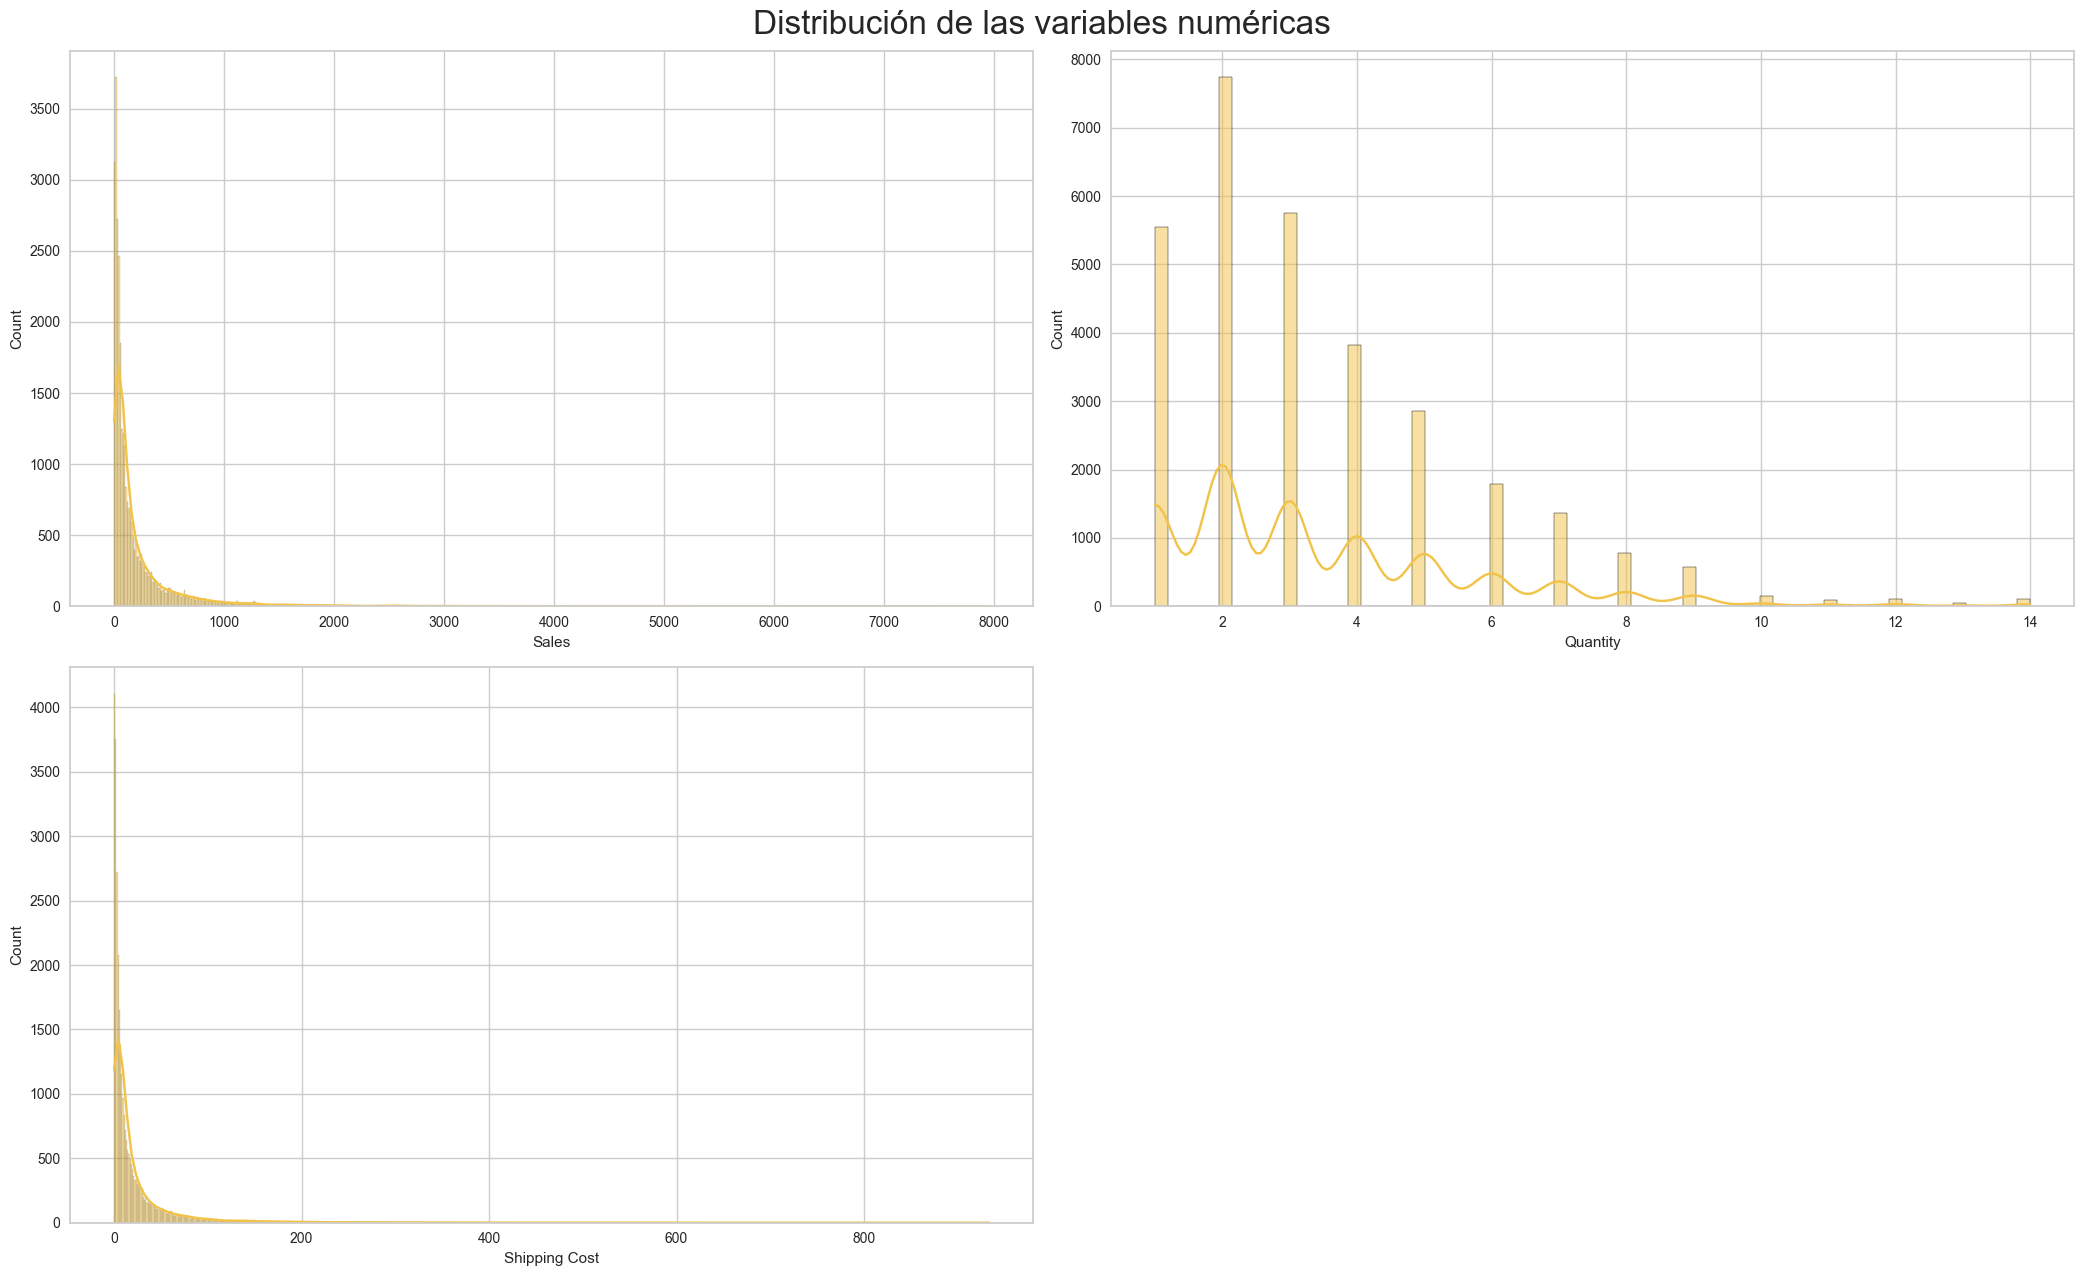

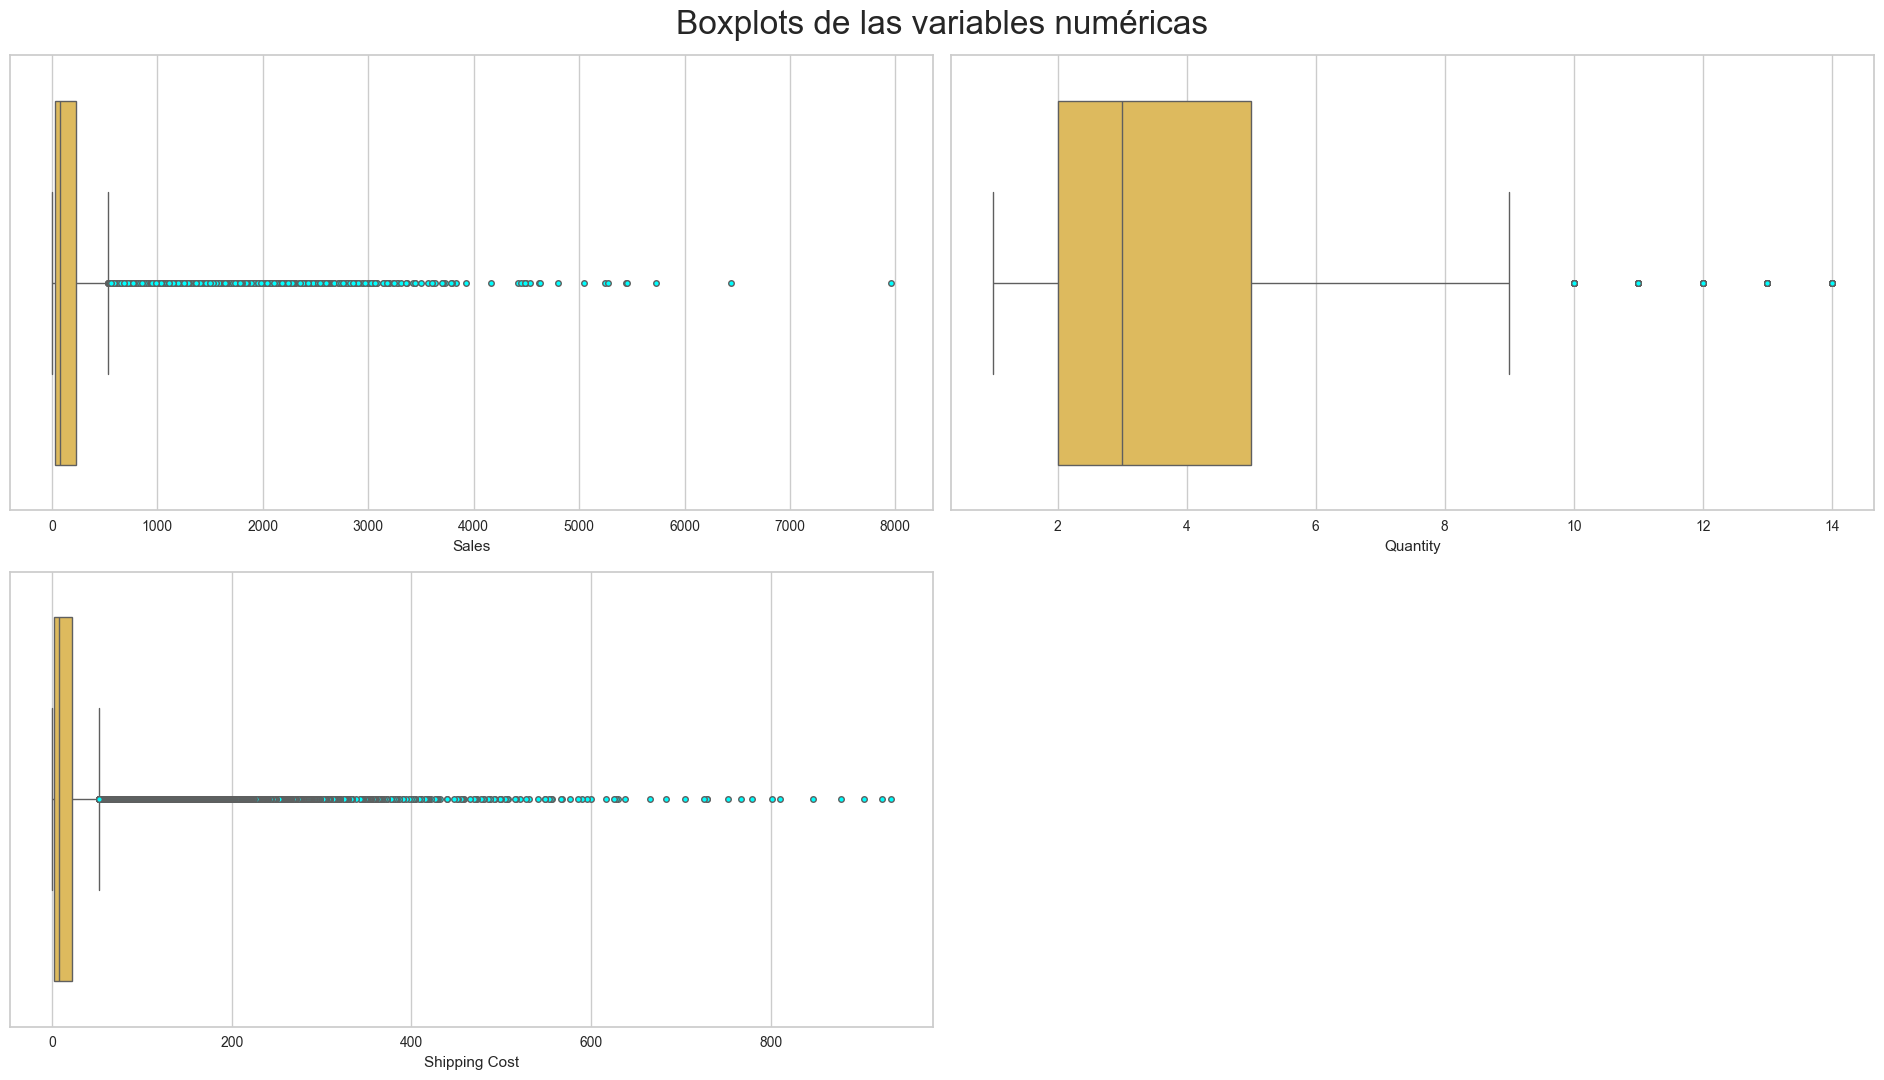

In [8]:
preprocesar_cluster = sc.Exploracion(df)
preprocesar_cluster.visualizar_numericas()

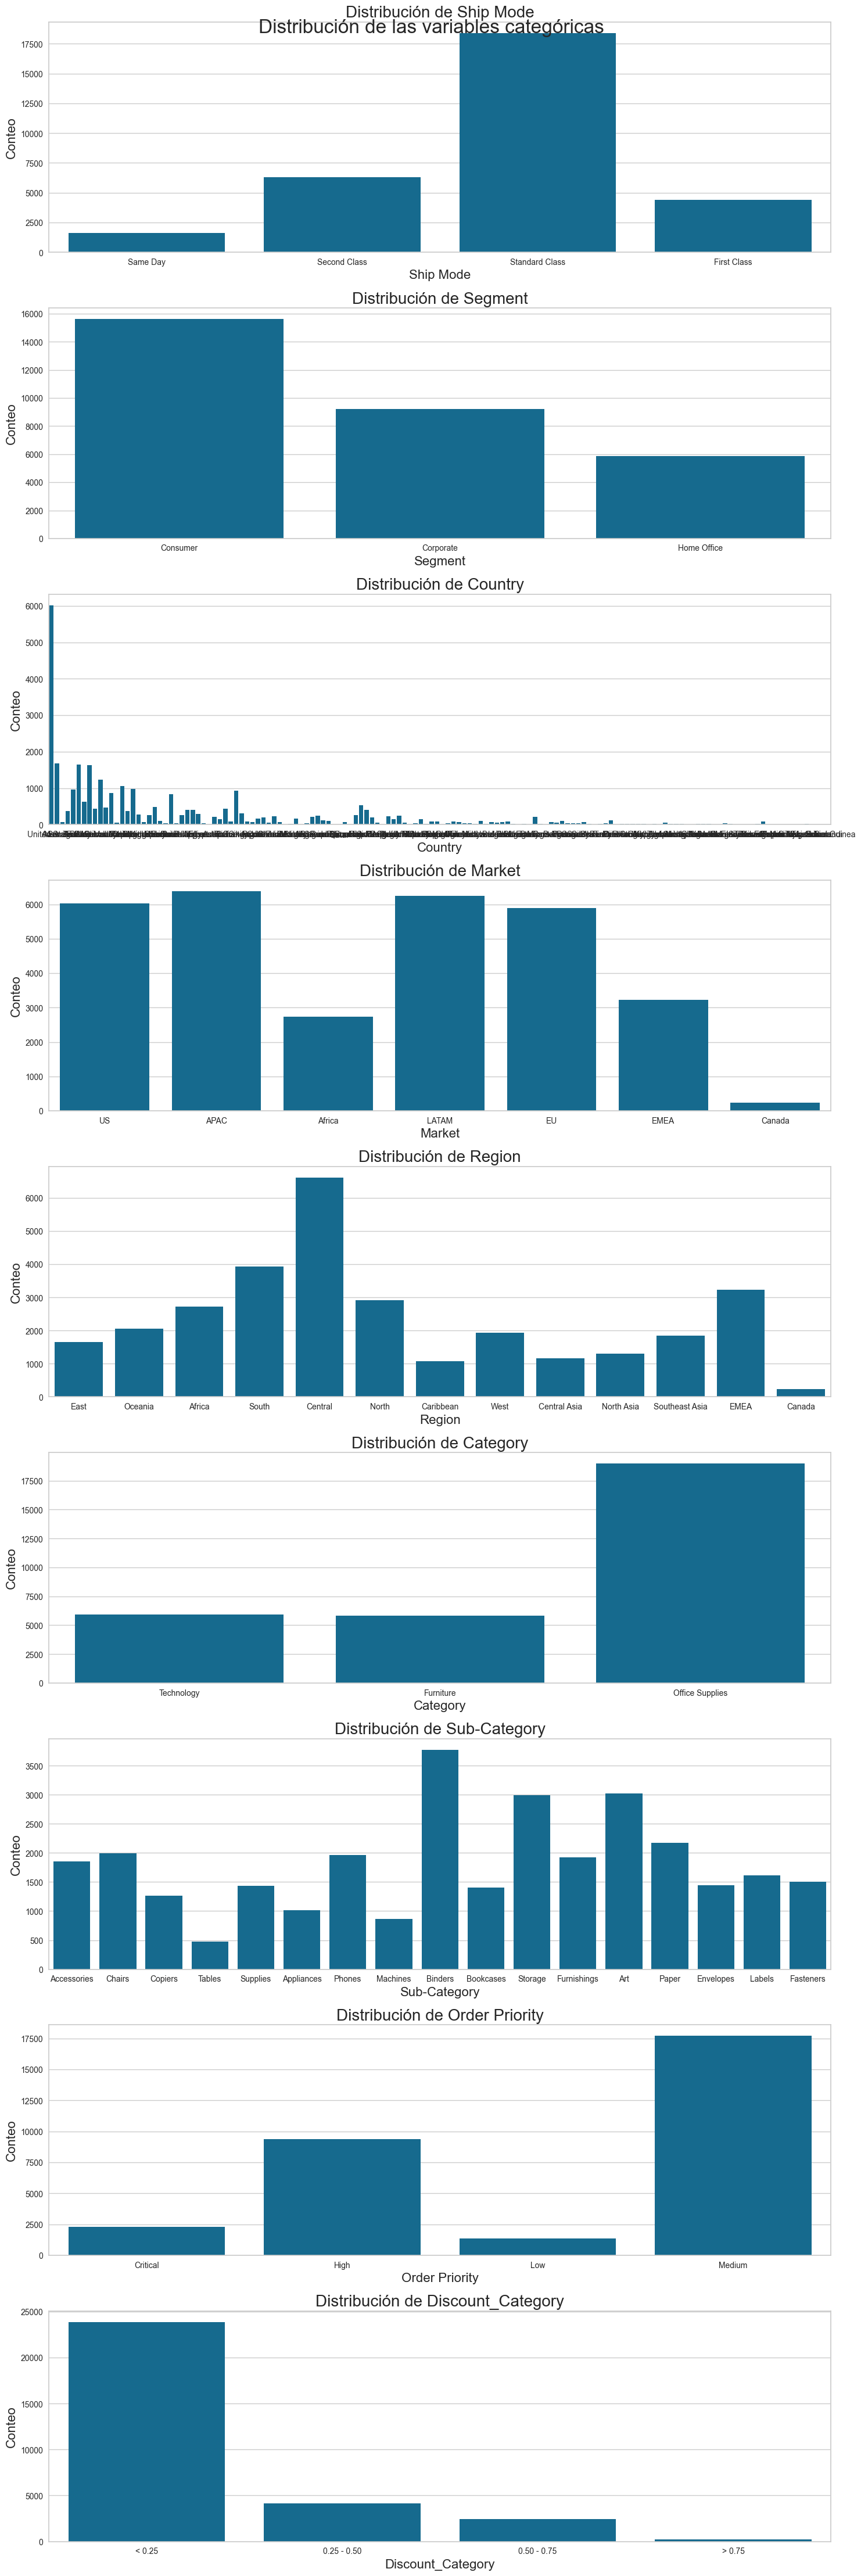

In [9]:
preprocesar_cluster.visualizar_categoricas()

## Outliers

<Axes: xlabel='Sales', ylabel='Shipping Cost'>

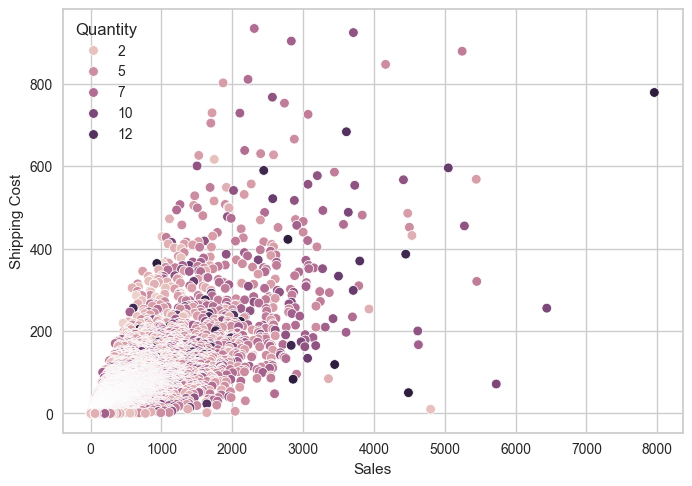

In [10]:
sns.scatterplot(x='Sales', y='Shipping Cost', data=df, hue='Quantity')

In [12]:
df[(df['Sales'] > 4500) & (df['Shipping Cost'] < 400)]

,Ship Mode,Segment,Country,Market,Region,Category,Sub-Category,Sales,Quantity,Shipping Cost,Order Priority,Discount_Category
165,Standard Class,Home Office,India,APAC,Central Asia,Furniture,Tables,5451.300,6,320.27,Medium,< 0.25
279,Standard Class,Home Office,New Zealand,APAC,Oceania,Technology,Phones,6439.800,10,255.36,Medium,< 0.25
462,Standard Class,Corporate,France,EU,Central,Office Supplies,Appliances,4618.215,9,200.06,Medium,< 0.25
668,Standard Class,Home Office,Spain,EU,South,Technology,Phones,4627.368,8,166.71,Medium,< 0.25
2405,Second Class,Corporate,Spain,EU,South,Technology,Phones,5726.160,10,71.46,Critical,< 0.25
12850,First Class,Corporate,United States,US,West,Technology,Machines,4799.984,2,10.34,Medium,< 0.25


In [13]:
df_filtrado = df[~((df['Sales'] > 4500) & (df['Shipping Cost'] < 400))]

## Estandarizar 

In [14]:
lista_num = df.select_dtypes(include=['int64', 'float64']).columns.tolist() # saco mis columnas numéricas

if 'Sales' in lista_num:
    lista_num.remove('Sales')

In [15]:
f.escalar_columnas_metodo(df, lista_num, 'robust')

,Ship Mode,Segment,Country,Market,Region,Category,Sub-Category,Sales,Quantity,Shipping Cost,Order Priority,Discount_Category
0,Same Day,Consumer,United States,US,East,Technology,Accessories,2309.650,1.333333,46.172483,Critical,< 0.25
1,Second Class,Corporate,Australia,APAC,Oceania,Furniture,Chairs,3709.395,2.000000,45.676969,Critical,< 0.25
2,Same Day,Consumer,Senegal,Africa,Africa,Technology,Copiers,2832.960,1.666667,44.650548,Critical,< 0.25
3,Standard Class,Consumer,New Zealand,APAC,Oceania,Furniture,Tables,5244.840,1.000000,43.421236,High,< 0.25
4,Second Class,Corporate,United States,US,South,Office Supplies,Supplies,4164.050,0.666667,41.833998,High,< 0.25
...,...,...,...,...,...,...,...,...,...,...,...,...
30718,Standard Class,Corporate,United States,US,Central,Office Supplies,Appliances,1.624,-0.333333,-0.365404,Medium,> 0.75
30719,First Class,Consumer,Brazil,LATAM,South,Office Supplies,Paper,84.000,0.666667,-0.365404,High,< 0.25
30720,Standard Class,Home Office,Australia,APAC,Oceania,Office Supplies,Binders,58.050,0.666667,-0.365902,Medium,< 0.25
30721,Same Day,Corporate,Japan,APAC,North Asia,Office Supplies,Fasteners,65.100,0.666667,-0.365902,Medium,< 0.25


In [16]:
lista_col_cat = df.select_dtypes(include=['object', 'category'])

In [17]:
asunciones = se.Asunciones(dataframe=df, columna_numerica='Sales')

for categoria in lista_col_cat:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = se.TestEstadisticos(df, "Sales", categoria)
    test.run_all_tests()
    print("\n###########################\n")

Estamos analizando la variable SHIP MODE
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Ship Mode las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Same Day', 'Second Class', 'Standard Class', 'First Class']

Realizando test de Kruskal...
Estadístico de prueba: 1.532218929697752
Valor p: 0.6748544293065264
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,18.4127,0.3445,-10.0654,46.8909,First Class-Same Day
1,10.1048,0.5287,-9.0755,29.2850,First Class-Second Class
2,6.9057,0.6996,-9.4670,23.2785,First Class-Standard Class
3,-8.3080,0.8630,-35.6274,19.0115,Same Day-Second Class
4,-11.5070,0.6505,-36.9341,13.9201,Same Day-Standard Class
5,-3.1990,0.9392,-17.4614,11.0633,Second Class-Standard Class



###########################

Estamos analizando la variable SEGMENT
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Segment las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Consumer', 'Corporate', 'Home Office']

Realizando test de Kruskal...
Estadístico de prueba: 0.14747783632290207
Valor p: 0.9289141848081399
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-1.4871,0.9523,-13.1922,10.2179,Consumer-Corporate
1,6.0605,0.5501,-7.5667,19.6877,Consumer-Home Office
2,7.5476,0.4593,-7.3214,22.4166,Corporate-Home Office



###########################

Estamos analizando la variable COUNTRY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Country las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['United States', 'Australia', 'Senegal', 'New Zealand', 'Brazil', 'France', 'Italy', 'Mexico', 'El Salvador', 'Germany', 'Dominican Republic', 'India', 'Mozambique', 'China', 'Nicaragua', 'United Kingdom', 'Morocco', 'Bangladesh', 'Netherlands', 'Spain', 'Malaysia', 'Ecuador', 'Indonesia', 'Somalia', 'South Africa', 'Iran', 'Philippines', 'Egypt', 'Lithuania', 'Lesotho', 'Austria', 'Japan', 'Cuba', 'Romania', 'Turkey', 'Guatemala', 'Singapore', 'Angola', 'Pakistan', 'Colombia', 'Ghana', 'Ukraine', 'Zambia', 'Liberia', 'Georgia', 'Poland', 'Montenegro', 'Madagascar', 'Russia', 'Canada', 'Sweden', 'Myanmar (Burma)', 'Jamaica', 'Qatar', 'Tanzania', 'Republic of the Congo', 'Iraq', 'Nigeria', 'Honduras', 'Saudi Ar

,meandiff,p-adj,lower,upper,group_diff
0,-202.9608,1.0000,-736.7535,330.8318,Afghanistan-Albania
1,-195.5964,0.9969,-507.9563,116.7634,Afghanistan-Algeria
2,-68.8276,1.0000,-404.8315,267.1763,Afghanistan-Angola
3,-176.9046,0.9979,-462.6243,108.8152,Afghanistan-Argentina
4,-54.9771,1.0000,-322.4686,212.5143,Afghanistan-Australia
...,...,...,...,...,...
10291,27.5124,1.0000,-219.4584,274.4832,Vietnam-Zambia
10292,-145.6064,1.0000,-416.6278,125.4151,Vietnam-Zimbabwe
10293,154.0971,1.0000,-311.8228,620.0171,Yemen-Zambia
10294,-19.0217,1.0000,-498.1244,460.0811,Yemen-Zimbabwe



###########################

Estamos analizando la variable MARKET
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Market las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['US', 'APAC', 'Africa', 'LATAM', 'EU', 'EMEA', 'Canada']

Realizando test de Kruskal...
Estadístico de prueba: 1716.3789862025735
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-121.5602,0.0000,-146.9785,-96.1419,APAC-Africa
1,-128.8774,0.0000,-201.9391,-55.8157,APAC-Canada
2,-139.3626,0.0000,-163.3647,-115.3604,APAC-EMEA
3,-10.4308,0.7258,-30.5121,9.6506,APAC-EU
4,-77.9787,0.0000,-97.7607,-58.1967,APAC-LATAM
5,-93.6727,0.0000,-113.6374,-73.7080,APAC-US
6,-7.3172,1.0000,-82.1310,67.4967,Africa-Canada
7,-17.8024,0.5369,-46.7023,11.0976,Africa-EMEA
8,111.1295,0.0000,85.3930,136.8659,Africa-EU
9,43.5815,0.0000,18.0780,69.0851,Africa-LATAM



###########################

Estamos analizando la variable REGION
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Region las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['East', 'Oceania', 'Africa', 'South', 'Central', 'North', 'Caribbean', 'West', 'Central Asia', 'North Asia', 'Southeast Asia', 'EMEA', 'Canada']

Realizando test de Kruskal...
Estadístico de prueba: 1199.038106929626
Valor p: 2.7902818765884973e-249
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-7.3172,1.0000,-91.5057,76.8713,Africa-Canada
1,31.4058,0.5090,-13.6224,76.4341,Africa-Caribbean
2,70.9087,0.0000,42.4597,99.3576,Africa-Central
3,146.2816,0.0000,102.5843,189.9789,Africa-Central Asia
4,-17.8024,0.8434,-50.3237,14.7189,Africa-EMEA
...,...,...,...,...,...
73,-21.4171,0.8649,-61.5143,18.6801,Oceania-Southeast Asia
74,-67.3848,0.0000,-106.9280,-27.8416,Oceania-West
75,34.8152,0.0575,-0.4812,70.1116,South-Southeast Asia
76,-11.1525,0.9977,-45.8182,23.5132,South-West



###########################

Estamos analizando la variable CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Technology', 'Furniture', 'Office Supplies']

Realizando test de Kruskal...
Estadístico de prueba: 8581.314221135679
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-263.6727,0.0,-276.1438,-251.2016,Furniture-Office Supplies
1,33.6318,0.0,18.2865,48.9770,Furniture-Technology
2,297.3045,0.0,284.9440,309.6649,Office Supplies-Technology



###########################

Estamos analizando la variable SUB-CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Sub-Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Accessories', 'Chairs', 'Copiers', 'Tables', 'Supplies', 'Appliances', 'Phones', 'Machines', 'Binders', 'Bookcases', 'Storage', 'Furnishings', 'Art', 'Paper', 'Envelopes', 'Labels', 'Fasteners']

Realizando test de Kruskal...
Estadístico de prueba: 14495.277810513775
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,261.9451,0.0,217.7786,306.1117,Accessories-Appliances
1,-146.2313,0.0,-179.6377,-112.8249,Accessories-Art
2,-158.5130,0.0,-190.6334,-126.3927,Accessories-Binders
3,347.3106,0.0,307.2513,387.3699,Accessories-Bookcases
4,166.7007,0.0,130.1791,203.2223,Accessories-Chairs
...,...,...,...,...,...
131,-346.8277,0.0,-386.1645,-307.4910,Phones-Supplies
132,312.0549,0.0,254.4225,369.6872,Phones-Tables
133,-120.1018,0.0,-156.4600,-83.7437,Storage-Supplies
134,538.7807,0.0,483.1388,594.4227,Storage-Tables



###########################

Estamos analizando la variable ORDER PRIORITY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Order Priority las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Critical', 'High', 'Low', 'Medium']

Realizando test de Kruskal...
Estadístico de prueba: 2.2209055885349125
Valor p: 0.527842369324178
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-10.0812,0.6641,-32.7814,12.6191,Critical-High
1,-12.8332,0.7567,-46.2298,20.5634,Critical-Low
2,-11.5569,0.5160,-33.1728,10.0590,Critical-Medium
3,-2.7521,0.9946,-31.1060,25.6018,High-Low
4,-1.4757,0.9903,-13.9600,11.0086,High-Medium
5,1.2764,0.9994,-26.2171,28.7698,Low-Medium



###########################

Estamos analizando la variable DISCOUNT_CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Discount_Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['< 0.25', '0.25 - 0.50', '0.50 - 0.75', '> 0.75']

Realizando test de Kruskal...
Estadístico de prueba: 1573.4528041879555
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-98.5660,0.0000,-123.1863,-73.9458,0.25 - 0.50-0.50 - 0.75
1,51.8601,0.0000,35.5906,68.1296,0.25 - 0.50-< 0.25
2,-111.3041,0.0002,-181.0292,-41.5790,0.25 - 0.50-> 0.75
3,150.4261,0.0000,129.9245,170.9277,0.50 - 0.75-< 0.25
4,-12.7381,0.9673,-83.5703,58.0942,0.50 - 0.75-> 0.75
5,-163.1642,0.0000,-231.5436,-94.7847,< 0.25-> 0.75



###########################



- Resultados:
    - Ship Mode: no tiene orden
    - Segment: no tiene orden.
    - Country: tiene orden.
    - Market : tiene orden
    - Region: tiene orden
    - Category: tiene orden.
    - Sub-Category: tiene orden
    - Order Priotity: no tiene orden.
    - Discount Category: tiene orden.

In [18]:
diccionario_encoding = {"onehot": ['Ship Mode', 'Segment', 'Order Priority'], # no metemos ninguna columna porque todas nuestras columnas tienen orden
                        "dummies": [], # no metemos ninguna columna porque todas tienen orden
                        'ordinal' : {},
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ["Country", "Region", "Market", "Category", "Sub-Category", "Discount_Category"]
                        }

In [19]:
encoding = se.Encoding(df, diccionario_encoding, "Sales")
df_encode = encoding.one_hot_encoding()
df_encode = encoding.target_encoding()
df_encode.head()

,Ship Mode,Segment,Sales,Quantity,Shipping Cost,Order Priority,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,Country,Region,Market,Category,Sub-Category,Discount_Category
0,Same Day,Consumer,2309.650,1.333333,46.172483,Critical,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,182.532253,184.773808,182.532253,400.021358,218.828213,235.316719
1,Second Class,Corporate,3709.395,2.000000,45.676969,Critical,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,270.879959,266.800494,272.332092,371.369332,387.416057,235.000365
2,Same Day,Consumer,2832.960,1.666667,44.650548,Critical,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,239.333981,160.771041,160.771041,405.462806,615.178466,235.000365
3,Standard Class,Consumer,5244.840,1.000000,43.421236,High,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,213.966975,260.299623,279.198498,370.531832,746.876916,238.030150
4,Second Class,Corporate,4164.050,0.666667,41.833998,High,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,182.721408,209.199795,182.721408,108.037390,86.820739,235.000365


In [20]:
df_encode.drop(columns=['Ship Mode', 'Segment', 'Order Priority'], inplace=True)

In [21]:
df_encode.shape

(30723, 20)

In [22]:
df_encode.to_csv('../../Datos/Datos_Modelo_3/Modelo_3_CL_1.csv')